In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
neigb = 'South End'

data  =  pd.read_excel('../01-Data/00-GoogleData/180905_venue_data.xlsx')
data = data[data['WeekTotals']>0].reset_index(drop=True)
data = data[data['neighborhood']==neigb].reset_index(drop=True)

labels = ['name','mapped_venue_type','lat','long','price_category','type_count_in_neighborhood',
          'type_density_in_neighborhood','neighborhood','google_id','venue_type','WeekTotals']
features = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

data_labels = data[labels]
data = data.drop(labels,axis=1)
print("Business/Venue dataset has {} records with {} features each".format(*data.shape))
data.head()

Business/Venue dataset has 165 records with 13 features each


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,visit_venue_density,walk_score,transit_score,bike_score,transit_summary,average_walk_score
0,0,547,534,464,541,298,57,9.963265,95.0,97.0,81.0,"59 nearby routes: 44 bus, 15 rail, 0 other",91.000000
1,554,595,532,638,532,0,0,178.187500,97.0,100.0,77.0,"58 nearby routes: 43 bus, 15 rail, 0 other",91.333333
2,13,26,7,18,8,5,484,6.678571,97.0,100.0,77.0,"62 nearby routes: 45 bus, 16 rail, 1 other",91.333333
3,1079,974,944,898,1353,1139,944,45.253086,96.0,96.0,82.0,"59 nearby routes: 44 bus, 15 rail, 0 other",91.333333
4,492,565,590,615,597,0,0,11.669388,88.0,77.0,88.0,"33 nearby routes: 28 bus, 5 rail, 0 other",84.333333


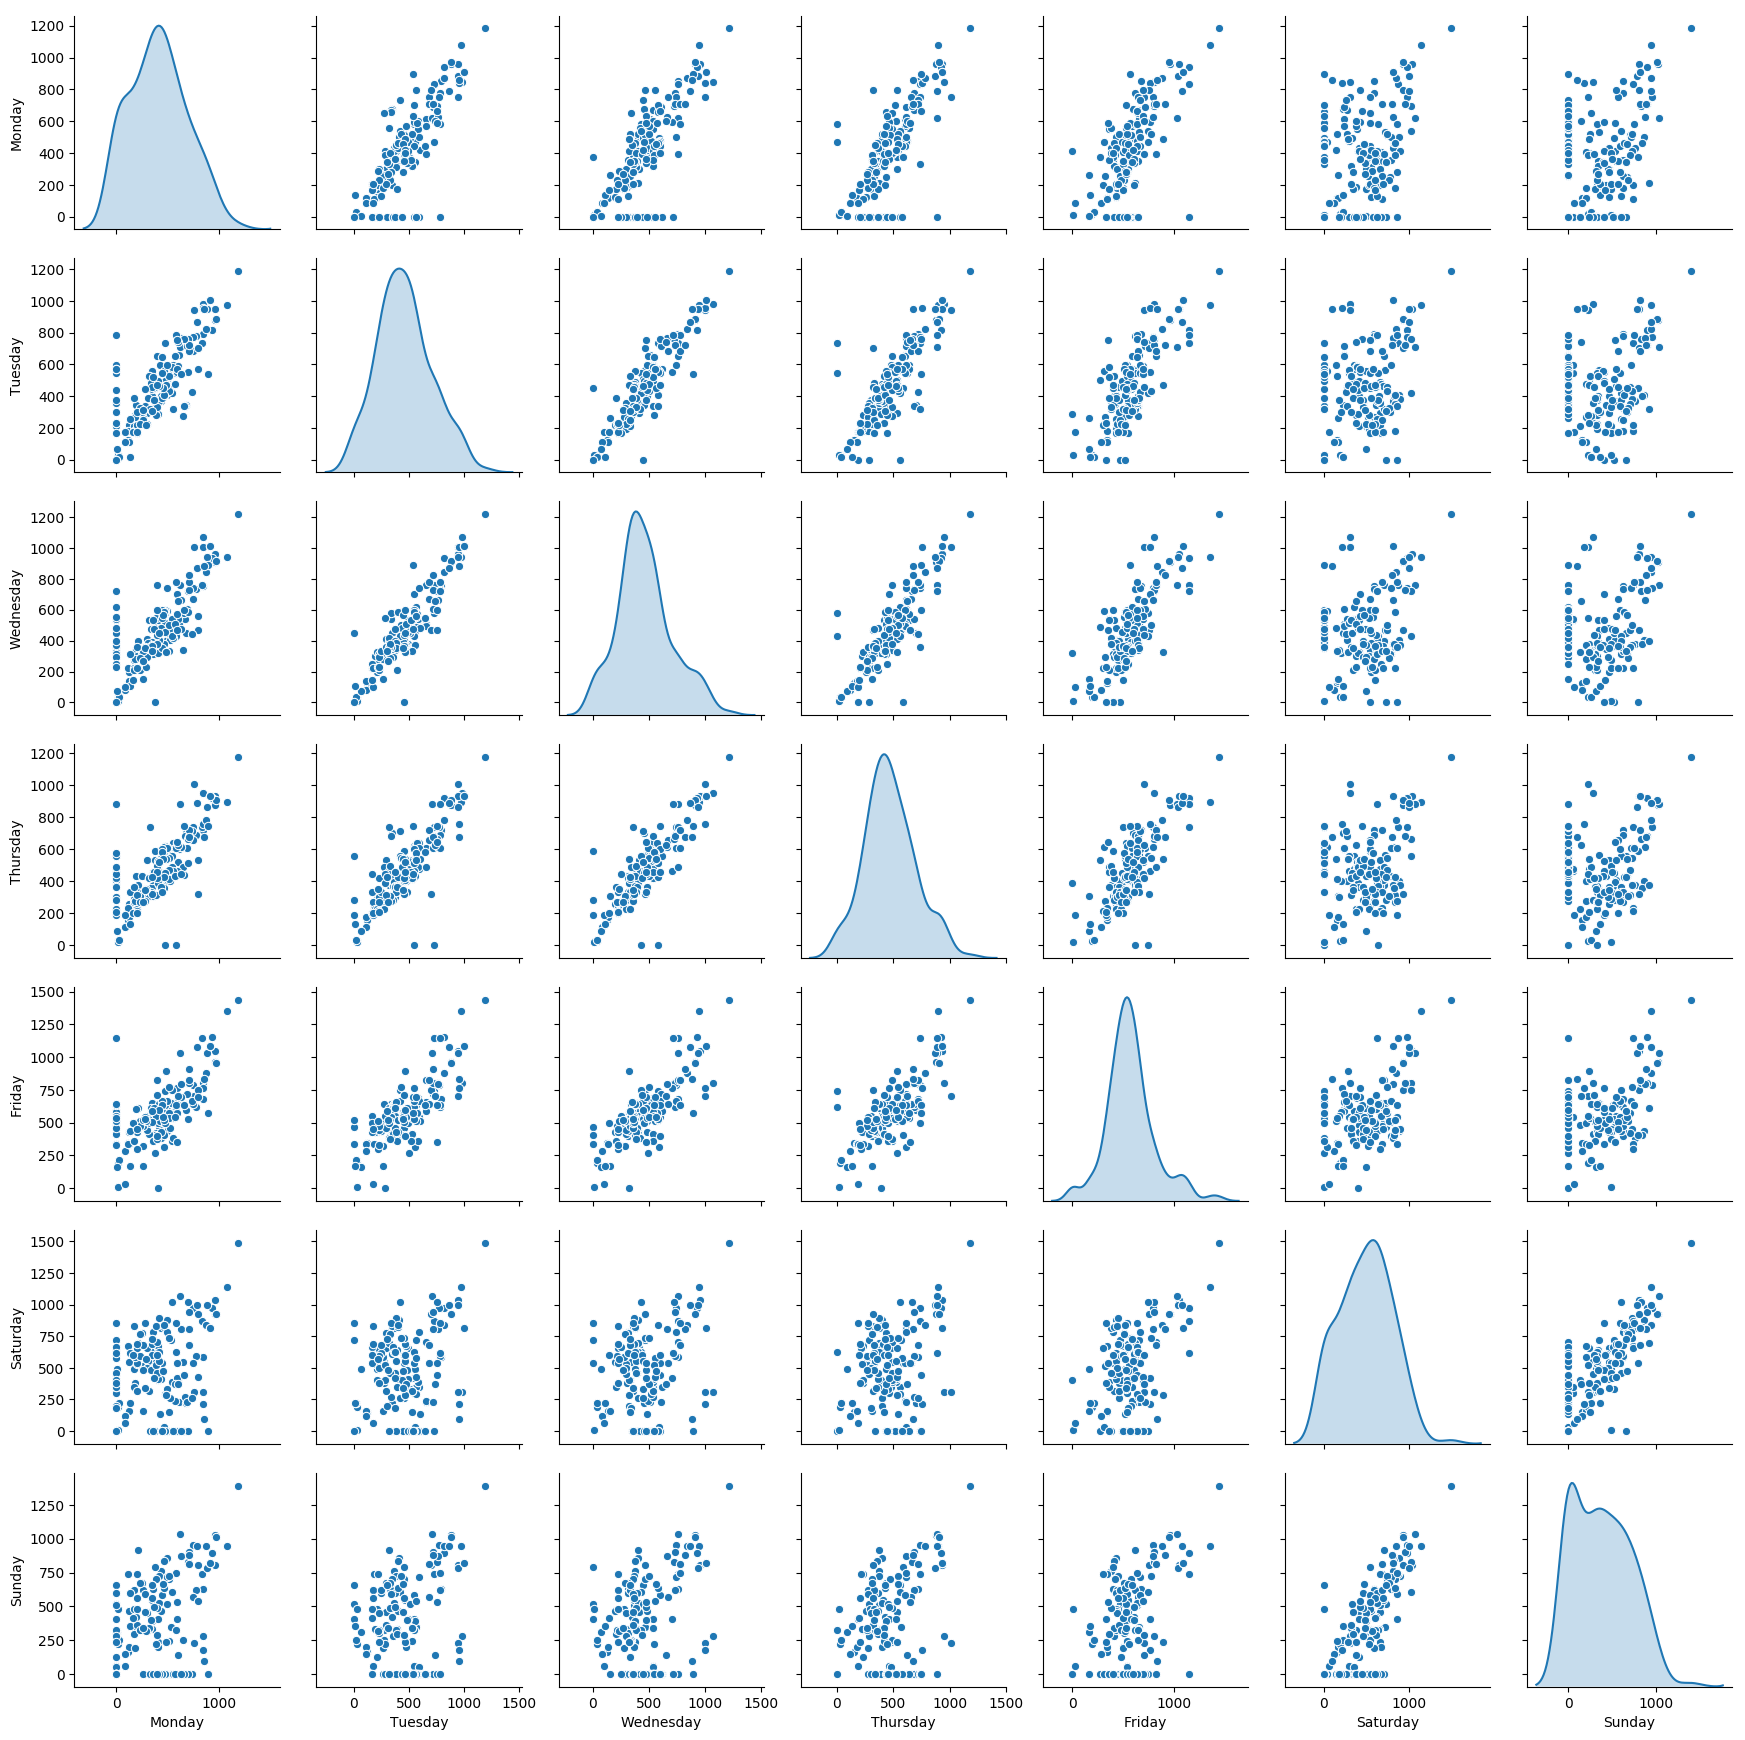

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

sns.pairplot(data=data, diag_kind='kde')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


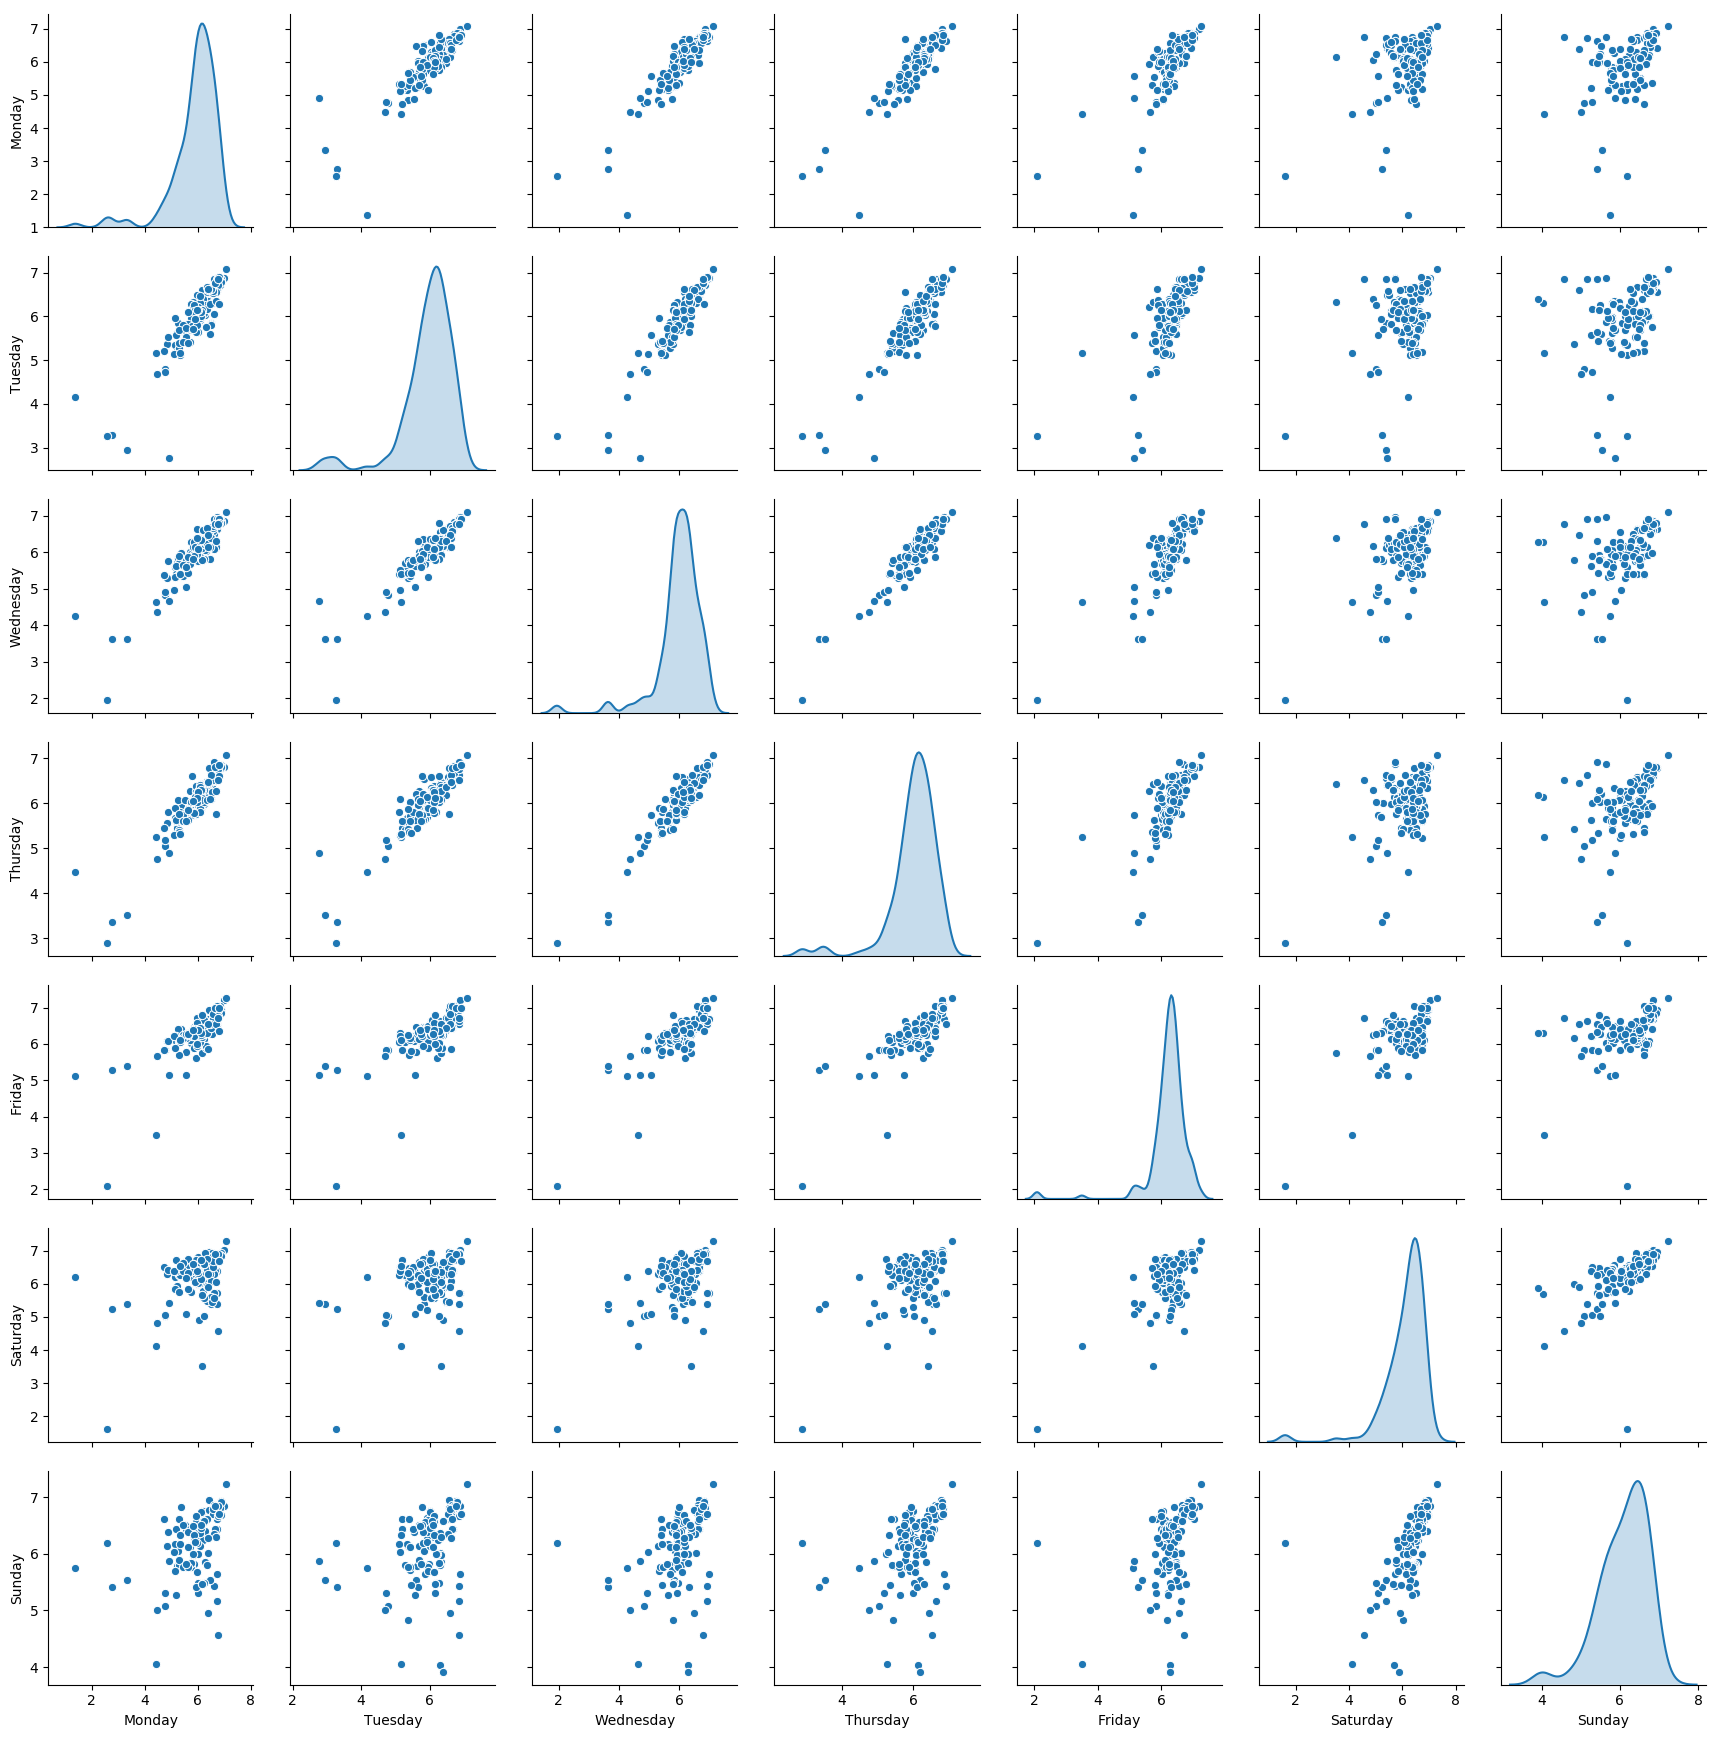

In [207]:
log_data = np.log(data)
                  
sns.pairplot(log_data, diag_kind='kde')

# PCA

In [208]:
from  sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(data)

reduced_data = pca.transform(data)

reduced_data = pd.DataFrame(reduced_data, columns=['Dimension_1','Dimension_2'])

Text(0.5,1,'PC plane with original feature projections.')

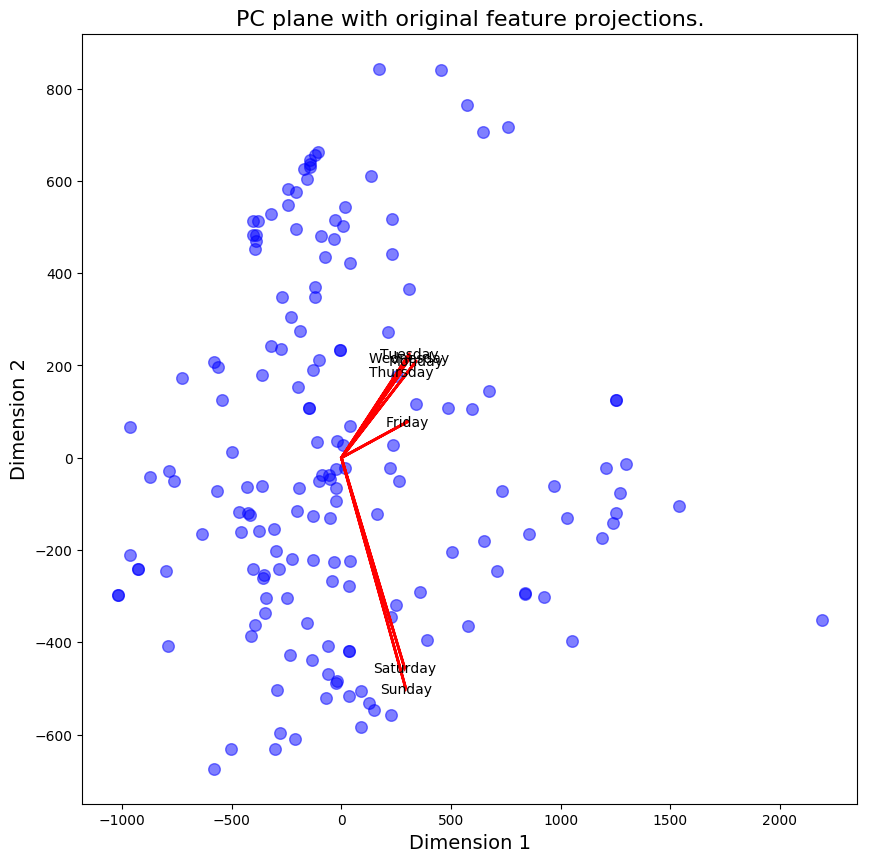

In [209]:
fig, ax = plt.subplots(figsize=(10,10))

#scatterplot of reduced data
ax.scatter(x=reduced_data.loc[:,'Dimension_1'],y=reduced_data.loc[:,'Dimension_2'],facecolors='b',edgecolors='b',
          s=70, alpha=0.5)

feature_vectors = pca.components_.T

arrow_size, text_pos = 800.0, 800.0

for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', 
                 ha='center', va='center', fontsize=10)
        
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("PC plane with original feature projections.", fontsize=16)

In [210]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

KMeans_clusterer = KMeans(n_clusters=4).fit(reduced_data)

preds = KMeans_clusterer.predict(reduced_data)

centers = KMeans_clusterer.cluster_centers_

score = silhouette_score(reduced_data, preds)
print("KMeans Clusters with a silhouette score of:",score)

KMeans Clusters with a silhouette score of: 0.419977892584


Text(0.5,1,'Cluster Learning on PCA_Reduced Data')

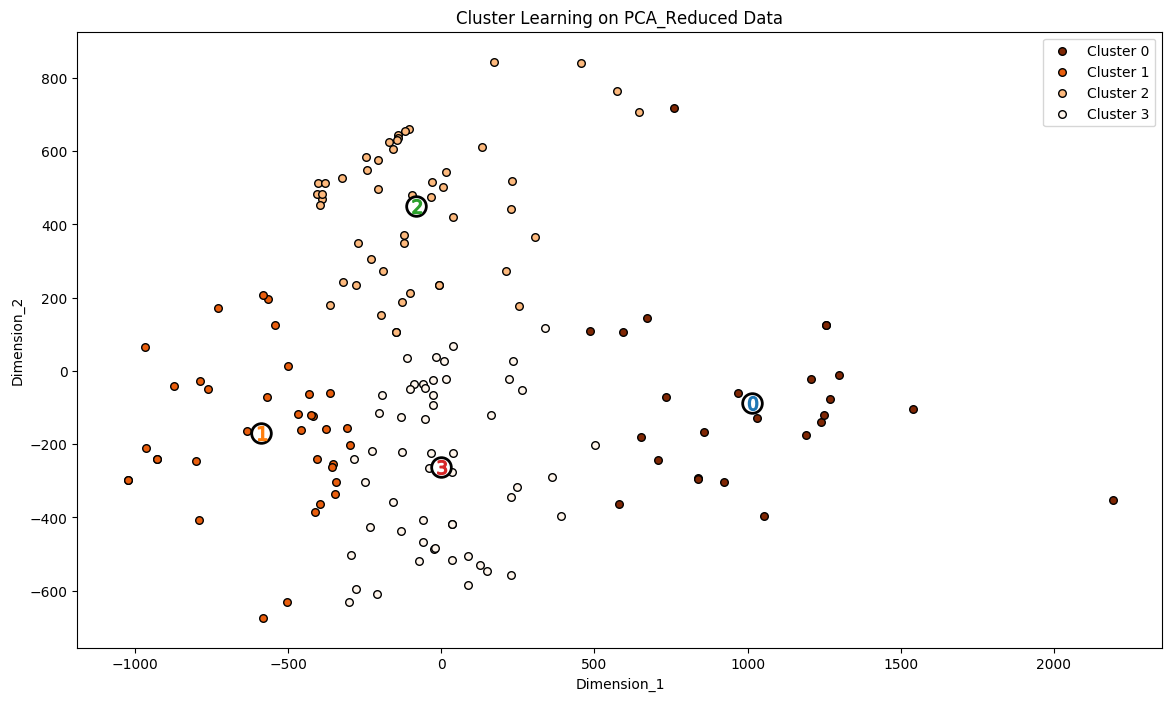

In [211]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(14,8))

predictions = pd.DataFrame(preds, columns=['Cluster'])
plot_data = pd.concat([predictions, reduced_data], axis=1)

cmap = cm.get_cmap('Oranges_r')

#plot points based on assigned cluster
for i, cluster in plot_data.groupby('Cluster'):
    cluster.plot(ax=ax, kind='scatter',x='Dimension_1', y = 'Dimension_2',
                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30, edgecolors='black')
    
#plot centers with indicators    
for i, c in enumerate(centers):
    ax.scatter(x=c[0], y=c[1], color = 'white', edgecolors='black', \
              alpha = 1, linewidth = 2, marker = 'o', s=200)
    ax.scatter(x=c[0], y=c[1], marker='$%d$'%(i), alpha=1,s=100)
    
#set plot title
ax.set_title("Cluster Learning on PCA_Reduced Data")

In [212]:
true_centers  = pca.inverse_transform(centers)
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers),columns=data.keys())
true_centers.index = segments
display(true_centers)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Segment 0,821.0,831.0,837.0,799.0,946.0,908.0,810.0
Segment 1,119.0,190.0,193.0,232.0,337.0,375.0,272.0
Segment 2,495.0,559.0,556.0,549.0,587.0,203.0,69.0
Segment 3,344.0,391.0,396.0,411.0,548.0,641.0,547.0


import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps

palette=["C0", "C1", "k","C2"]

#figure size
plot_size = (12,11)

x_min = -71.07
y_min = 42.3425
x_max = -71.05
y_max = 42.356

building_shapefile_path = '../01-Data/01-Shapefiles//boston_buildings.shp'
shapefile_path = '../01-Data/01-Shapefiles/Hydrography_Polygon.shp'
building_shapefile = gpd.read_file(building_shapefile_path)
shapefile = gpd.read_file(shapefile_path) #shapefile of boston waterway

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

clustered_data = pd.concat([plot_data, data_labels],axis=1)
fig, ax = plt.subplots(figsize=plot_size)

#define plot ranges
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax = building_shapefile.plot(ax=ax,alpha=.5,edgecolor='grey',facecolor='#ffffff')
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
sns.scatterplot(x='long',y='lat',data=clustered_data,hue='Cluster',s=400,palette=palette,alpha=.5)
'''plt.savefig("../data_archives/plot_exports/180824/cluster_plotcolor_3.jpg", dpi=300,
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)'''

In [213]:
from  scipy.stats import mode

venue_types = list(set(clustered_data['mapped_venue_type'].values))

c = []
d = []

for item in venue_types:
    v = item
    m = mode(clustered_data[clustered_data['mapped_venue_type']==item]['Cluster'])[0]
    c.append(v)
    d.append(m[0])

cluster_groups = pd.DataFrame({'type':c, 'cluster':d})
cluster_groups.sort_values(by='cluster')

,type,cluster
10,food,0
0,professional_services,1
6,bar,1
8,transportation,1
2,education,2
3,health_wellness,2
4,government,2
5,finance,2
1,retail,3
7,grocery,3


In [214]:
seg_plot_data = true_centers.transpose()
seg_plot_data = seg_plot_data.reset_index()
seg_plot_data['Day'] = seg_plot_data['index']
seg_plot_data.drop('index',axis=1,inplace=True)

for i in range(len(seg_plot_data)):
    seg_plot_data.at[i,'Day'] = "{}_{}".format(i,seg_plot_data.loc[i]['Day'])
seg_plot_data

,Segment 0,Segment 1,Segment 2,Segment 3,Day
0,821.0,119.0,495.0,344.0,0_Monday
1,831.0,190.0,559.0,391.0,1_Tuesday
2,837.0,193.0,556.0,396.0,2_Wednesday
3,799.0,232.0,549.0,411.0,3_Thursday
4,946.0,337.0,587.0,548.0,4_Friday
5,908.0,375.0,203.0,641.0,5_Saturday
6,810.0,272.0,69.0,547.0,6_Sunday


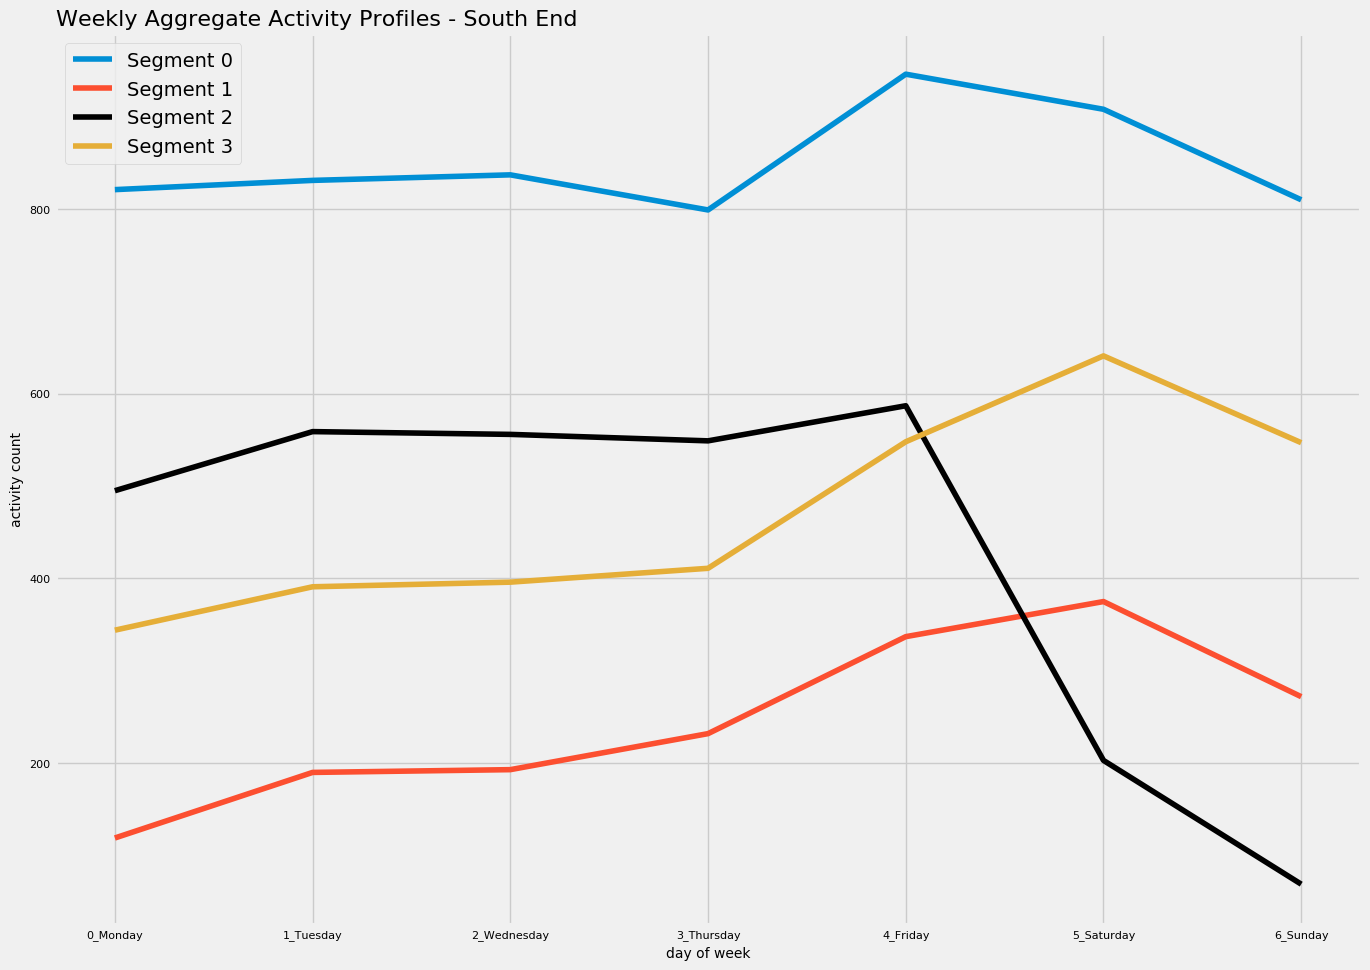

In [215]:
plt.style.use('fivethirtyeight' )
plt.figure(figsize=(15,11))

palette=["C0", "C1", "k","C2"]

sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 0'],color=palette[0])
sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 1'],color=palette[1])
sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 2'],color=palette[2])
sns.lineplot(x=seg_plot_data['Day'],y=seg_plot_data['Segment 3'],color=palette[3])
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel('day of week',fontsize=10)
plt.ylabel('activity count',fontsize=10)
plt.title('Weekly Aggregate Activity Profiles - {}'.format(neigb),fontsize=16, loc='left')
labels=seg_plot_data.columns
plt.legend(labels,loc='upper left')

plt.savefig("../01-Data/02-Plots/cluster_pattern_{}.jpg".format(neigb), dpi=300,
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)